In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
REPO_ROOT = Path.cwd().parent.parent
BACKEND_DIR = REPO_ROOT / "backend"
sys.path.insert(0, str(BACKEND_DIR))

from analytics.forecasting.prophet import ProphetForecaster



In [ ]:
SYMBOL = "TSLA"
INTERVAL = "1wk"
PERIOD = "5y"

print(f"Fetching data for {SYMBOL}...")

# Fix: Use multi_level_index=False to avoid unwanted MultiIndex columns
df = yf.download(tickers=SYMBOL, period=PERIOD, interval=INTERVAL, multi_level_index=False)

# Standardize: reset index and rename for clarity
df = df.reset_index().rename(columns={"Date": "timestamp", "Close": "close"})
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

# Result: By selecting the 'close' column from a flat DataFrame, prices becomes a Series
prices = df.set_index("timestamp")["close"].astype(float).dropna()

print(f"Loaded {len(prices)} rows. Latest date: {prices.index.max()}")
print(f"Data type of prices: {type(prices)}") # Verified as <class 'pandas.core.series.Series'>

prices.head()

prices.plot(title=f"{SYMBOL} Close Price", figsize=(10,4))
plt.show()



Fetching data for TSLA...


NameError: name 'yf' is not defined

In [3]:
TEST_SIZE = 30

def backtest_one_step(prices_full: pd.Series, test_size: int, model_factory, min_train: int):
    preds = []
    split_idx = len(prices_full) - test_size

    for i in range(split_idx, len(prices_full)):
        train = prices_full.iloc[:i]
        actual = float(prices_full.iloc[i])
        ts = prices_full.index[i]

        if len(train) < min_train:
            continue

        model = model_factory()
        model.fit(train)
        fc = model.forecast(periods=1)
        yhat = float(fc["point_forecast"][0])

        preds.append({"timestamp": ts, "y_true": actual, "y_pred": yhat})

    return pd.DataFrame(preds)

pred_prophet = backtest_one_step(
    prices, TEST_SIZE,
    model_factory=lambda: ProphetForecaster(confidence_level=0.95),
    min_train=10
)

pred_prophet.head()

c:\capstone_project_unfc\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
13:09:48 - cmdstanpy - INFO - Chain [1] start processing
13:09:54 - cmdstanpy - INFO - Chain [1] done processing
13:09:55 - cmdstanpy - INFO - Chain [1] start processing
13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:55 - cmdstanpy - INFO - Chain [1] start processing
13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:56 - cmdstanpy - INFO - Chain [1] start processing
13:09:56 - cmdstanpy - INFO - Chain [1] done processing
13:09:57 - cmdstanpy - INFO - Chain [1] start processing
13:09:57 - cmdstanpy - INFO - Chain [1] done processing
13:09:57 - cmdstanpy - INFO - Chain [1] start processing
13:09:57 - cmdstanpy - INFO - Chain [1] done processing
13:09:58 - c

,timestamp,y_true,y_pred
0,2025-08-04,329.649994,332.0674
1,2025-08-11,330.559998,336.7527
2,2025-08-18,340.010010,337.7473
3,2025-08-25,333.869995,338.8951
4,2025-09-01,350.839996,344.2451



Final Metrics: {'MAE': np.float64(25.234161017252607), 'RMSE': 33.98524734268997, 'MAPE_%': np.float64(5.852775737839918)}


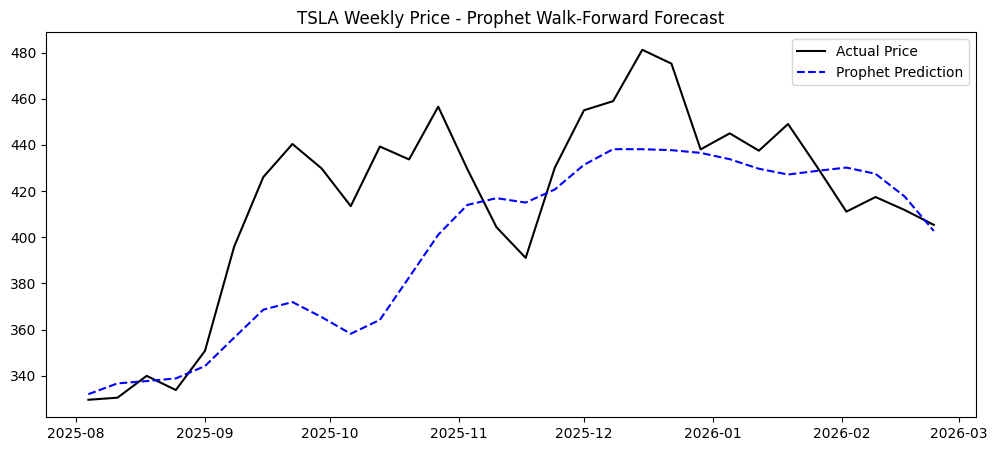

In [4]:
from math import sqrt

def get_metrics(df_pred):
    y = df_pred["y_true"].to_numpy()
    yhat = df_pred["y_pred"].to_numpy()
    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat)**2))
    mape = np.mean(np.abs((y - yhat) / y)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

print("\nFinal Metrics:", get_metrics(pred_prophet))

plt.figure(figsize=(12, 5))
plt.plot(pred_prophet["timestamp"], pred_prophet["y_true"], label="Actual Price", color='black')
plt.plot(pred_prophet["timestamp"], pred_prophet["y_pred"], label="Prophet Prediction", color='blue', linestyle='--')
plt.title(f"{SYMBOL} Weekly Price - Prophet Walk-Forward Forecast")
plt.legend()
plt.show()

In [5]:
OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
OUTDIR.mkdir(parents=True, exist_ok=True)

path = OUTDIR / "pred_prophet_weekly_price.parquet"
pred_prophet.to_parquet(path, index=False)

print("Saved:", path)
print("Rows:", len(pred_prophet))

Saved: c:\capstone_project_unfc\model\notebooks\artifacts\pred_prophet_weekly_price.parquet
Rows: 30
